# Using the NGFS survey to train AstroCV

The Next Generation Fornax Survey (NGFS; [Munoz et al. 2015](http://adsabs.harvard.edu/abs/2015ApJ...813L..15M)) is an ongoing multi-wavelength survey of the central 30 deg2 of the Fornax galaxy cluster (Ferguson 1989). We are using Blanco/DECam for doing near-ultraviolet (NUV) and optical photometry as well as VISTA/VIRCam (Sutherland et al. 2015) for doing near-infrared (NIR) photometry of the same field. 

This notebook shows how to read the NGFS images and catalogs and create a train dataset for AstroCV.

**Author**: Roberto Muñoz <br />
**Email**: rmunoz@metricarts.com

In [251]:
import numpy as np
import pandas as pd

from skimage import io
import cv2
import imutils

from astropy.io import ascii
from pyavm import AVM

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [302]:
%%capture
im_file='../data/ngfs/ngfs_tile1_rgb_asinh_v3.jpg'
im_data=cv2.imread(im_file)
im_size= im_data.shape

avm = AVM.from_image(im_file)
w = avm.to_wcs()
w.naxis1=im_size[1]
w.naxis2=im_size[0]

In [303]:
print("Image size: ", im_size)
print("WCS projection type: ", w.wcs.ctype)

Image size:  (28848, 31733, 3)
WCS projection type:  ['RA---TAN', 'DEC--TAN']


In [304]:
im_display=cv2.resize(im_data, None, fx=0.1, fy=0.1, interpolation = cv2.INTER_AREA)
im_display=cv2.cvtColor(im_display, cv2.COLOR_BGR2RGB)
print("Resized image size: ", im_display.shape)

Resized image size:  (2885, 3173, 3)


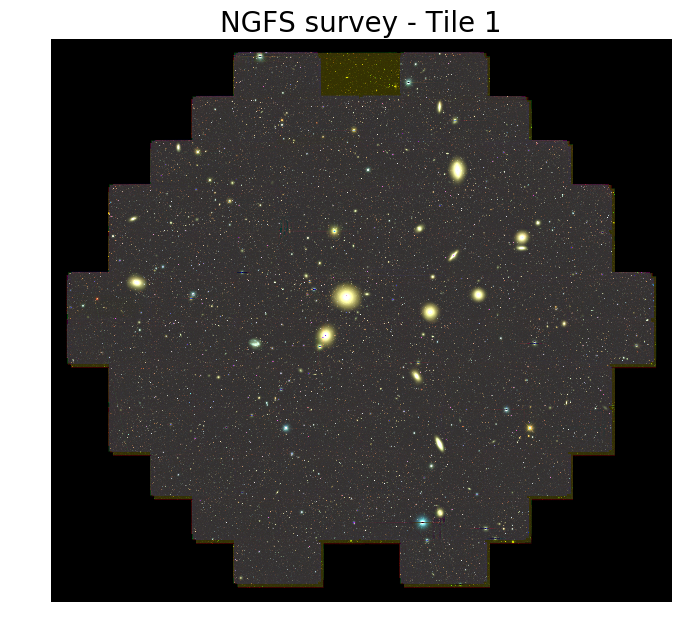

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(im_display)
ax.axis('off')
ax.set_title('NGFS survey - Tile 1', fontsize=20)

# Read the HyperLeda catalog

In [278]:
fornax_hyperleda_file='../data/ngfs/hyperleda_fornax_cluster_catalog.csv'
fornax_df=pd.read_csv(fornax_hyperleda_file)
print('Number of galaxies: ', len(fornax_df))
fornax_df.head()

Number of galaxies:  278


,name,type,ra,dec,morph_type,logd25,logr25,pa
0,PGC644823,G,53.924688,-35.76793,E,0.35,0.07,175.0
1,PGC652054,G,53.760450,-35.19700,Sd,0.35,0.06,65.5
2,PGC653033,G,53.961333,-35.12225,E,0.37,0.11,76.0
3,PGC654062,G,54.217536,-35.04236,Sc,0.38,0.08,124.0
4,PGC647329,G,54.255740,-35.56632,Sc,0.39,0.15,69.5


In [279]:
fornax_coo=w.wcs_world2pix(fornax_df[['ra','dec']].values.tolist(), 1)
fornax_coo_df=pd.DataFrame(fornax_coo, columns=['x','y'])
fornax_coo_df['y']=(fornax_coo_df['y']-im_size[0])*-1

fornax_coo_df['x']=np.round(fornax_coo_df['x'],2)
fornax_coo_df['y']=np.round(fornax_coo_df['y'],2)
fornax_coo_df.head()

,x,y
0,22838.60,17614.80
1,24725.87,9811.74
2,22484.52,8772.73
3,19619.28,7665.64
4,19169.48,14837.42


In [280]:
fornax_df=fornax_df.join(fornax_coo_df)
fornax_df.head()

,name,type,ra,dec,morph_type,logd25,logr25,pa,x,y
0,PGC644823,G,53.924688,-35.76793,E,0.35,0.07,175.0,22838.60,17614.80
1,PGC652054,G,53.760450,-35.19700,Sd,0.35,0.06,65.5,24725.87,9811.74
2,PGC653033,G,53.961333,-35.12225,E,0.37,0.11,76.0,22484.52,8772.73
3,PGC654062,G,54.217536,-35.04236,Sc,0.38,0.08,124.0,19619.28,7665.64
4,PGC647329,G,54.255740,-35.56632,Sc,0.39,0.15,69.5,19169.48,14837.42


## Compute diameter in pixels based en logd25

In [281]:
fornax_df['diameter']=np.round( (10**fornax_df['logd25'])*0.1 / np.abs(w.wcs.cdelt[0]*60), 2)
print(fornax_df['diameter'].min(), fornax_df['diameter'].max())
print("Median value: ", fornax_df['diameter'].median())

51.08 1941.99
Median value:  97.33


In [282]:
theta=np.linspace(0,2*np.pi,100)
def compute_rectangle(row):
    x = np.round(row['x'] + row['a']*np.cos(theta)*np.cos(row['alpha']) - row['b']*np.sin(theta)*np.sin(row['alpha']),2)
    y = np.round(row['y'] + row['a']*np.cos(theta)*np.sin(row['alpha']) + row['b']*np.sin(theta)*np.cos(row['alpha']),2)
    return np.max(x)-np.min(x), np.max(y)-np.min(y)

# Compute semi-major and semi-minor axis
fornax_df['a']=fornax_df['diameter']/2
fornax_df['b']=fornax_df['a']/10**fornax_df['logr25']
fornax_df['alpha']=(fornax_df['pa']-90.)*np.pi/180

# Fill NA
fornax_df['alpha'].fillna(0., inplace=True)
fornax_df['a'].fillna(fornax_df['a'].median(), inplace=True)
fornax_df['b'].fillna(fornax_df['b'].median(), inplace=True)

fornax_df['width'], fornax_df['height'] = zip(*fornax_df.apply(compute_rectangle, axis=1))
fornax_df.head()

,name,type,ra,dec,morph_type,logd25,logr25,pa,x,y,diameter,a,b,alpha,width,height
0,PGC644823,G,53.924688,-35.76793,E,0.35,0.07,175.0,22838.60,17614.80,51.08,25.540,21.738065,1.483530,43.53,51.02
1,PGC652054,G,53.760450,-35.19700,Sd,0.35,0.06,65.5,24725.87,9811.74,51.08,25.540,22.244410,-0.427606,49.99,45.68
2,PGC653033,G,53.961333,-35.12225,E,0.37,0.11,76.0,22484.52,8772.73,53.49,26.745,20.760729,-0.244346,52.85,42.31
3,PGC654062,G,54.217536,-35.04236,Sc,0.38,0.08,124.0,19619.28,7665.64,54.73,27.365,22.761216,0.593412,52.01,48.57
4,PGC647329,G,54.255740,-35.56632,Sc,0.39,0.15,69.5,19169.48,14837.42,56.01,28.005,19.826022,-0.357792,54.26,41.99


In [283]:
fornax_df[ (fornax_df['name']=='NGC1399') | (fornax_df['name']=='NGC1375') | (fornax_df['name']=='NGC1381')]

,name,type,ra,dec,morph_type,logd25,logr25,pa,x,y,diameter,a,b,alpha,width,height
134,NGC1375,G,53.820087,-35.26565,S0,1.36,0.36,89.8,24051.66,10746.49,522.69,261.345,114.081230,-0.003491,522.56,228.13
135,NGC1381,G,54.132151,-35.29516,S0,1.41,0.42,139.3,20561.60,11130.23,586.47,293.235,111.484838,0.860447,418.04,467.69
145,NGC1399,G,54.621120,-35.45063,E,1.93,0.04,NaN,15099.51,13248.94,1941.99,970.995,885.557965,0.000000,1941.50,1770.90


## Create numeric class based on morphplogical type

In [284]:
fornax_df['morph_type'].unique()

array(['E', 'Sd', 'Sc', 'S0', 'E-S0', 'Sab', 'Sb', 'SBc', 'I', 'S0-a',
       'IB', 'Sbc', 'Sa', 'S?'], dtype=object)

In [285]:
conditions = [
    (fornax_df['morph_type'] == 'E') | (fornax_df['morph_type'] == 'E-S0'),
    (fornax_df['morph_type'] == 'I') | (fornax_df['morph_type'] == 'IB')]
choices = [0, 3]
fornax_df['class'] = np.select(conditions, choices, default=1)
fornax_df.head()

,name,type,ra,dec,morph_type,logd25,logr25,pa,x,y,diameter,a,b,alpha,width,height,class
0,PGC644823,G,53.924688,-35.76793,E,0.35,0.07,175.0,22838.60,17614.80,51.08,25.540,21.738065,1.483530,43.53,51.02,0
1,PGC652054,G,53.760450,-35.19700,Sd,0.35,0.06,65.5,24725.87,9811.74,51.08,25.540,22.244410,-0.427606,49.99,45.68,1
2,PGC653033,G,53.961333,-35.12225,E,0.37,0.11,76.0,22484.52,8772.73,53.49,26.745,20.760729,-0.244346,52.85,42.31,0
3,PGC654062,G,54.217536,-35.04236,Sc,0.38,0.08,124.0,19619.28,7665.64,54.73,27.365,22.761216,0.593412,52.01,48.57,1
4,PGC647329,G,54.255740,-35.56632,Sc,0.39,0.15,69.5,19169.48,14837.42,56.01,28.005,19.826022,-0.357792,54.26,41.99,1


## Sort by diameter and print results

In [286]:
fornax_df.sort_values('diameter', ascending=False, inplace=True)
fornax_df.head()

,name,type,ra,dec,morph_type,logd25,logr25,pa,x,y,diameter,a,b,alpha,width,height,class
145,NGC1399,G,54.621120,-35.45063,E,1.93,0.04,NaN,15099.51,13248.94,1941.99,970.995,885.557965,0.000000,1941.50,1770.90,0
144,NGC1404,G,54.716311,-35.59423,E,1.70,0.06,163.3,14041.20,15216.06,1143.53,571.765,497.986497,1.279326,1008.75,1131.82,0
143,NGC1380,G,54.114948,-34.97609,S0,1.66,0.32,6.2,20773.21,6762.77,1042.91,521.455,249.584055,-1.462586,508.81,1038.07,1
142,NGC1427,G,55.580861,-35.39273,E,1.64,0.18,77.8,4387.61,12515.70,995.97,497.985,329.015427,-0.212930,983.23,676.65,0
141,NGC1386,G,54.192542,-35.99925,S0-a,1.56,0.43,24.6,19851.63,20766.70,828.42,414.210,153.893607,-1.141445,444.06,763.94,1


# Read the NGFS catalog

In [287]:
ngfs_file='../data/ngfs/NGFS_dwarfs_catalog.csv'
ngfs_df=pd.read_csv(ngfs_file)
print('Number of galaxies: ', len(ngfs_df))
ngfs_df.head()

Number of galaxies:  285


,name,ra,dec,m_i,reff_arcsec,morph_type
0,NGFS033415-353341,53.564451,-35.561258,21.18,2.506,dwarf_nucleated
1,NGFS033746-350310,54.442189,-35.052727,19.83,2.712,dwarf_nucleated
2,NGFS034218-352819,55.574258,-35.471924,20.73,3.293,dwarf_nucleated
3,NGFS033703-354802,54.264088,-35.800585,19.78,4.242,dwarf_nucleated
4,NGFS033322-353620,53.342419,-35.605612,18.70,4.439,dwarf_nucleated


In [288]:
ngfs_df['type']='G'

In [289]:
ngfs_coo=w.wcs_world2pix(ngfs_df[['ra','dec']].values.tolist(), 1)
ngfs_coo_df=pd.DataFrame(ngfs_coo, columns=['x','y'])
ngfs_coo_df['y']=(ngfs_coo_df['y']-im_size[0])*-1

ngfs_coo_df['x']=np.round(ngfs_coo_df['x'],2)
ngfs_coo_df['y']=np.round(ngfs_coo_df['y'],2)
ngfs_coo_df.head()

,x,y
0,26868.84,14818.31
1,17101.03,7801.96
2,4472.55,13599.15
3,19067.14,18044.24
4,29334.52,15453.14


In [290]:
ngfs_df=ngfs_df.join(ngfs_coo_df)
ngfs_df.head()

,name,ra,dec,m_i,reff_arcsec,morph_type,type,x,y
0,NGFS033415-353341,53.564451,-35.561258,21.18,2.506,dwarf_nucleated,G,26868.84,14818.31
1,NGFS033746-350310,54.442189,-35.052727,19.83,2.712,dwarf_nucleated,G,17101.03,7801.96
2,NGFS034218-352819,55.574258,-35.471924,20.73,3.293,dwarf_nucleated,G,4472.55,13599.15
3,NGFS033703-354802,54.264088,-35.800585,19.78,4.242,dwarf_nucleated,G,19067.14,18044.24
4,NGFS033322-353620,53.342419,-35.605612,18.70,4.439,dwarf_nucleated,G,29334.52,15453.14


In [291]:
ngfs_df['diameter']=np.round(ngfs_df['reff_arcsec']*2*2/np.abs(w.wcs.cdelt[0]*3600), 2)
print(ngfs_df['diameter'].min(), ngfs_df['diameter'].max())
print("Median value: ", ngfs_df['diameter'].median())

14.8 426.09
Median value:  83.15


In [292]:
ngfs_df['diameter'].fillna((ngfs_df['diameter'].median()), inplace=True)
ngfs_df['width']=ngfs_df['diameter']
ngfs_df['height']=ngfs_df['diameter']
ngfs_df.head()

,name,ra,dec,m_i,reff_arcsec,morph_type,type,x,y,diameter,width,height
0,NGFS033415-353341,53.564451,-35.561258,21.18,2.506,dwarf_nucleated,G,26868.84,14818.31,38.12,38.12,38.12
1,NGFS033746-350310,54.442189,-35.052727,19.83,2.712,dwarf_nucleated,G,17101.03,7801.96,41.25,41.25,41.25
2,NGFS034218-352819,55.574258,-35.471924,20.73,3.293,dwarf_nucleated,G,4472.55,13599.15,50.09,50.09,50.09
3,NGFS033703-354802,54.264088,-35.800585,19.78,4.242,dwarf_nucleated,G,19067.14,18044.24,64.52,64.52,64.52
4,NGFS033322-353620,53.342419,-35.605612,18.70,4.439,dwarf_nucleated,G,29334.52,15453.14,67.52,67.52,67.52


## Create column class

In [293]:
ngfs_df['class'] = 3
ngfs_df.head()

,name,ra,dec,m_i,reff_arcsec,morph_type,type,x,y,diameter,width,height,class
0,NGFS033415-353341,53.564451,-35.561258,21.18,2.506,dwarf_nucleated,G,26868.84,14818.31,38.12,38.12,38.12,3
1,NGFS033746-350310,54.442189,-35.052727,19.83,2.712,dwarf_nucleated,G,17101.03,7801.96,41.25,41.25,41.25,3
2,NGFS034218-352819,55.574258,-35.471924,20.73,3.293,dwarf_nucleated,G,4472.55,13599.15,50.09,50.09,50.09,3
3,NGFS033703-354802,54.264088,-35.800585,19.78,4.242,dwarf_nucleated,G,19067.14,18044.24,64.52,64.52,64.52,3
4,NGFS033322-353620,53.342419,-35.605612,18.70,4.439,dwarf_nucleated,G,29334.52,15453.14,67.52,67.52,67.52,3


# Remove duplicated galaxies from the HyperLeda catalog

In [294]:
for i in range(len(ngfs_df)):
    print('\nInspecting NGFS galaxy ', i)
    fornax_duplicate=fornax_df[ (np.abs(fornax_df['ra']-ngfs_df.loc[i,'ra'])< 30/3600) & (np.abs(fornax_df['dec']-ngfs_df.loc[i,'dec'])< 30/3600) ]
    if len(fornax_duplicate)>0:
        fornax_index=fornax_duplicate.index.get_values()
        print('Removing duplicated galaxies from HyperLeda')
        print('NGFS: ', ngfs_df.loc[i,['ra','dec']])
        print('HyperLEda: ', fornax_df.loc[fornax_index,['ra','dec']])
        fornax_df.drop(fornax_index, inplace=True)
        
fornax_df.reset_index(inplace=True, drop=True)
fornax_df.head()


Inspecting NGFS galaxy  0

Inspecting NGFS galaxy  1

Inspecting NGFS galaxy  2

Inspecting NGFS galaxy  3

Inspecting NGFS galaxy  4

Inspecting NGFS galaxy  5

Inspecting NGFS galaxy  6

Inspecting NGFS galaxy  7

Inspecting NGFS galaxy  8
Removing duplicated galaxies from HyperLeda
NGFS:  ra      54.284
dec   -34.7313
Name: 8, dtype: object
HyperLEda:            ra       dec
9  54.283962 -34.73136

Inspecting NGFS galaxy  9

Inspecting NGFS galaxy  10

Inspecting NGFS galaxy  11
Removing duplicated galaxies from HyperLeda
NGFS:  ra     54.2915
dec   -35.3867
Name: 11, dtype: object
HyperLEda:            ra       dec
239  54.2916 -35.38675

Inspecting NGFS galaxy  12
Removing duplicated galaxies from HyperLeda
NGFS:  ra     54.3246
dec   -35.6992
Name: 12, dtype: object
HyperLEda:             ra       dec
45  54.324721 -35.69925

Inspecting NGFS galaxy  13
Removing duplicated galaxies from HyperLeda
NGFS:  ra     53.798
dec   -35.323
Name: 13, dtype: object
HyperLEda:            ra 

,name,type,ra,dec,morph_type,logd25,logr25,pa,x,y,diameter,a,b,alpha,width,height,class
0,NGC1399,G,54.621120,-35.45063,E,1.93,0.04,NaN,15099.51,13248.94,1941.99,970.995,885.557965,0.000000,1941.50,1770.90,0
1,NGC1404,G,54.716311,-35.59423,E,1.70,0.06,163.3,14041.20,15216.06,1143.53,571.765,497.986497,1.279326,1008.75,1131.82,0
2,NGC1380,G,54.114948,-34.97609,S0,1.66,0.32,6.2,20773.21,6762.77,1042.91,521.455,249.584055,-1.462586,508.81,1038.07,1
3,NGC1427,G,55.580861,-35.39273,E,1.64,0.18,77.8,4387.61,12515.70,995.97,497.985,329.015427,-0.212930,983.23,676.65,0
4,NGC1386,G,54.192542,-35.99925,S0-a,1.56,0.43,24.6,19851.63,20766.70,828.42,414.210,153.893607,-1.141445,444.06,763.94,1


## Join HyperLeda and NGFS catalogs

In [295]:
print('Number of galaxies in HyperLeda: ', len(fornax_df))
print('Number of galaxies in NGFS: ', len(ngfs_df))

fornax_df=fornax_df.append(ngfs_df)[['name','class','x','y','width','height']]

print('Number of galaxies in FULL catalog: ', len(fornax_df))
fornax_df.head()

Number of galaxies in HyperLeda:  206
Number of galaxies in NGFS:  285
Number of galaxies in FULL catalog:  491


,name,class,x,y,width,height
0,NGC1399,0,15099.51,13248.94,1941.50,1770.90
1,NGC1404,0,14041.20,15216.06,1008.75,1131.82
2,NGC1380,1,20773.21,6762.77,508.81,1038.07
3,NGC1427,0,4387.61,12515.70,983.23,676.65
4,NGC1386,1,19851.63,20766.70,444.06,763.94


# Display image and overplot galaxies

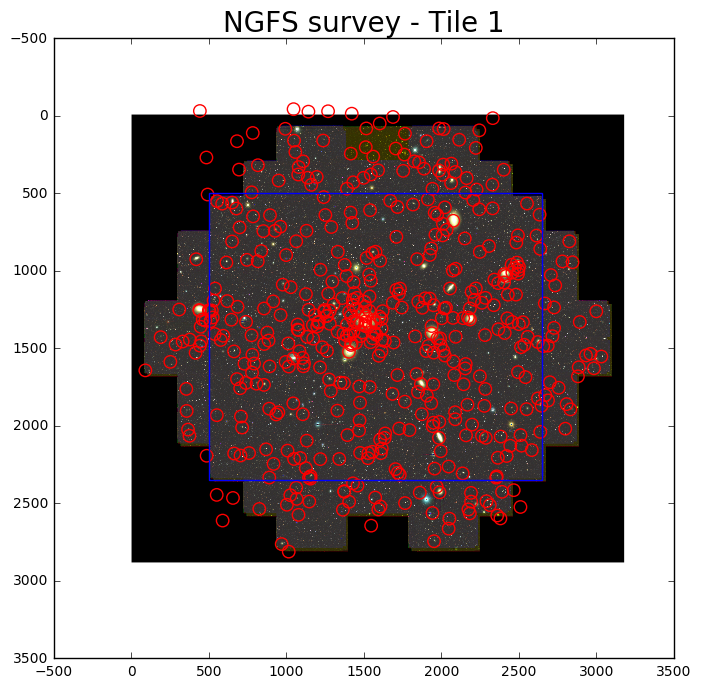

In [296]:
im_crop_range={'x':[500,2650], 'y':[500,2350]}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(im_display)
#ax.axis('off')
ax.set_title('NGFS survey - Tile 1', fontsize=20)

rect = patches.Rectangle((im_crop_range['x'][0],im_crop_range['y'][0]),im_crop_range['x'][1]-im_crop_range['x'][0],im_crop_range['y'][1]-im_crop_range['y'][0],linewidth=1,edgecolor='blue',facecolor='none')
ax.add_patch(rect)

plt.scatter(fornax_df['x']*0.1, fornax_df['y']*0.1, s=80, facecolors='none', edgecolors='r')
#fig.savefig('figures/fornax_cluster_hyperleda.jpg')

# Generate randomly distributed crop images

In [146]:
im_crop_range={'x':np.array([500,2650])*10, 'y':np.array([500,2350])*10}
im_crop_size=2000
im_pad_size=200

im_crop_x=np.random.randint(im_crop_range['x'][0],im_crop_range['x'][1]-im_crop_size, size=100)
im_crop_y=np.random.randint(im_crop_range['y'][0],im_crop_range['y'][1]-im_crop_size, size=100)

im_crop_xy=np.column_stack((im_crop_x,im_crop_y))
im_crop_xy

array([[ 8592,  7158],
       [24059, 10021],
       [16164, 18857],
       [15022,  5812],
       [24399, 18972],
       [19643, 19216],
       [ 8739, 14620],
       [17720,  9690],
       [14842, 17351],
       [19154, 10091],
       [21400, 12928],
       [10674, 11077],
       [19166,  9479],
       [11782, 14875],
       [13743,  6032],
       [ 7384, 19336],
       [ 6949, 19500],
       [18794, 10729],
       [21743, 17485],
       [13526, 20385],
       [18471, 15556],
       [10966,  9269],
       [12975, 18160],
       [11645, 19279],
       [ 6935,  9824],
       [ 5514,  7510],
       [10930, 13979],
       [13616, 11418],
       [17364,  5104],
       [ 9949, 12310],
       [ 6631, 18046],
       [ 7903, 17998],
       [ 5872, 10317],
       [10417, 18098],
       [15046, 10056],
       [20544, 11323],
       [10582,  9725],
       [11867, 12795],
       [23209,  9262],
       [ 5746,  6183],
       [21515, 19132],
       [16118, 15949],
       [ 8802, 18423],
       [ 98

In [310]:
for i, coo in enumerate(im_crop_xy):
    print("Processing crop image iteration: ", i)
    print("X,Y coordinates: ", coo)
    
    im_crop_file='../data/ngfs/train/ngfs_tile1_crop'+str(i)+'.jpg'
    cat_crop_file='../data/ngfs/train/ngfs_tile1_crop'+str(i)+'.dat'
    
    im_crop_data=im_data[coo[1]:coo[1]+im_crop_size, coo[0]:coo[0]+im_crop_size]
    cv2.imwrite(im_crop_file,im_crop_data)
    
    fornax_crop_df=fornax_df[(fornax_df['x']>coo[0]-im_pad_size) & (fornax_df['x']<coo[0]+im_crop_size+im_pad_size) & (fornax_df['y']>coo[1]-im_pad_size) & (fornax_df['y']<coo[1]+im_crop_size+im_pad_size)].copy()
    fornax_crop_df['tl_x']= np.round((fornax_crop_df['x']-coo[0]-fornax_crop_df['width']/2)/im_crop_size,4)
    fornax_crop_df['tl_y']= np.round((fornax_crop_df['y']-coo[1]-fornax_crop_df['height']/2)/im_crop_size,4)
    fornax_crop_df['br_x']= np.round((fornax_crop_df['x']-coo[0]+fornax_crop_df['width']/2)/im_crop_size,4)
    fornax_crop_df['br_y']= np.round((fornax_crop_df['y']-coo[1]+fornax_crop_df['height']/2)/im_crop_size,4)
    
    fornax_crop_df['tl_x']= fornax_crop_df['tl_x'].clip(0.,1.)
    fornax_crop_df['tl_y']= fornax_crop_df['tl_y'].clip(0.,1.)
    fornax_crop_df['br_x']= fornax_crop_df['br_x'].clip(0.,1.)
    fornax_crop_df['br_y']= fornax_crop_df['br_y'].clip(0.,1.)
    
    fornax_crop_df['x']=np.round((fornax_crop_df['tl_x']+fornax_crop_df['br_x'])/2.,4)
    fornax_crop_df['y']=np.round((fornax_crop_df['tl_y']+fornax_crop_df['br_y'])/2.,4)
    fornax_crop_df['width']=np.round(fornax_crop_df['br_x']-fornax_crop_df['tl_x'],4)
    fornax_crop_df['height']=np.round(fornax_crop_df['br_y']-fornax_crop_df['tl_y'],4)

    fornax_crop_df=fornax_crop_df[(fornax_crop_df['width']>0) & (fornax_crop_df['height']>0)]
    
    fornax_crop_df[['name','class','x','y','width','height']].to_csv(cat_crop_file, sep=' ', index=False, header=False)

Processing crop image iteration:  0
X,Y coordinates:  [8592 7158]
Processing crop image iteration:  1
X,Y coordinates:  [24059 10021]
Processing crop image iteration:  2
X,Y coordinates:  [16164 18857]
Processing crop image iteration:  3
X,Y coordinates:  [15022  5812]
Processing crop image iteration:  4
X,Y coordinates:  [24399 18972]
Processing crop image iteration:  5
X,Y coordinates:  [19643 19216]
Processing crop image iteration:  6
X,Y coordinates:  [ 8739 14620]
Processing crop image iteration:  7
X,Y coordinates:  [17720  9690]
Processing crop image iteration:  8
X,Y coordinates:  [14842 17351]
Processing crop image iteration:  9
X,Y coordinates:  [19154 10091]
Processing crop image iteration:  10
X,Y coordinates:  [21400 12928]
Processing crop image iteration:  11
X,Y coordinates:  [10674 11077]
Processing crop image iteration:  12
X,Y coordinates:  [19166  9479]
Processing crop image iteration:  13
X,Y coordinates:  [11782 14875]
Processing crop image iteration:  14
X,Y coord

# Display crop images

In [299]:
im_crop_file='../data/ngfs/train/ngfs_tile1_crop0.jpg'
im_crop_data=cv2.imread(im_crop_file)
im_crop_display=cv2.cvtColor(im_crop_data, cv2.COLOR_BGR2RGB)

print('Image crop coordinates: ', im_crop_xy[0])

Image crop coordinates:  [8592 7158]
Image crop size:  (2000, 2000, 3)


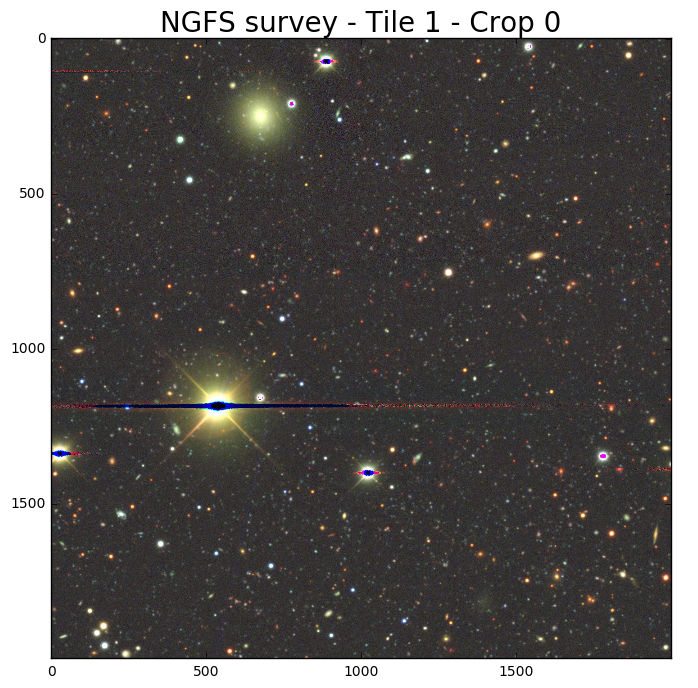

In [300]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(im_crop_display)
ax.set_title('NGFS survey - Tile 1 - Crop 0', fontsize=20)